# HOMEWORK-1 Deep Learning Systems:

### Load all Libraries:

In [54]:
# For torch functions
import torch

# for Neural network layers 
import torch.nn as nn

# For neural network functions:
import torch.nn.functional as F

# For Open ML datasets available in pytorch
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# for Optimization function in pytorch
import torch.optim as optim

# Ml Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random
from tqdm.notebook import tqdm
import pickle
from sklearn.decomposition import PCA
%matplotlib inline

In [100]:
!pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68503 sha256=9f5896f2d1c83ceb1a0125ea83d080b4e08ee43892569fdb3a4e92ce660ba22c
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [101]:
from MulticoreTSNE import MulticoreTSNE as TSNE

### Connect to GPU:

In [2]:
print(torch.__version__)
BATCH_SIZE = 64

1.6.0+cu101


In [3]:
print(torch.cuda.get_device_name(0))
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
device

Tesla T4
True


device(type='cuda', index=0)

In [4]:
!nvidia-smi

Sun Oct  4 22:44:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Problem 1: A Detailed View to MNIST Classification

## Train 5x5 Network:

### Load Data:

In [60]:
class FastMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Scale data to [0,1]
        self.data = self.data.unsqueeze(1).float().div(255)
        
        # Normalize it with the usual MNIST mean and std
        self.data = self.data.sub_(0.1307).div_(0.3081)
        
        # Put both data and targets on GPU in advance
        self.data, self.targets = self.data.to(device), self.targets.to(device)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

In [61]:
train_dataset = FastMNIST('data/MNIST', train=True, download=True)
test_dataset = FastMNIST('data/MNIST', train=False, download=True)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=10000, shuffle=False, num_workers=0)

In [62]:
# Check Data
print("Train Data:\n", train_dataset)
print("Test Data:\n", test_dataset)

Train Data:
 Dataset FastMNIST
    Number of datapoints: 60000
    Root location: data/MNIST
    Split: Train
Test Data:
 Dataset FastMNIST
    Number of datapoints: 10000
    Root location: data/MNIST
    Split: Test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


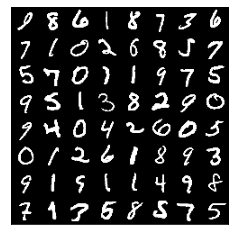

In [151]:
def reset_sns():
    sns.reset_orig()
## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    sns.reset_orig()
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(make_grid(images))

### Network Architecture:

In [81]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        # Define Layers:
        self.l1 = nn.Linear(784, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 1024)
        self.l4 = nn.Linear(1024, 1024)
        self.l5 = nn.Linear(1024, 10)

        # Define Activation functions:
        # self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.2)
        self.softmax = nn.LogSoftmax(dim = 1)


    def forward(self, x):
        # Pass the input tensor x through our layers:
        l1_out = self.relu(self.l1(x))
        l2_out = self.relu(self.l2(l1_out))
        l3_out = self.relu(self.l3(l2_out))
        l4_out = self.relu(self.l4(l3_out))
        l5_out = self.l5(l4_out)
        out = self.softmax(l5_out)

        return [l1_out, l2_out, l3_out, l4_out, l5_out, out] 

NN = NeuralNetwork().to(device)  # Intialize you NN

In [82]:
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

### Training Network:

In [83]:
# Loss Function
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

# Loss Optimizer
optimizer = optim.Adam(NN.parameters(), lr = 0.001)

# No:of times to train data
epochs = 5

for e in tqdm(range(epochs)):
    train_running_loss = 0.0
    train_acc = 0.0
    for i, (images, labels) in enumerate(trainloader):
        # Faltten the images 
        images = images.view(images.shape[0], -1)
        images, labels = images.to(device), labels.to(device)

        # set optimizer gradients to zero:
        optimizer.zero_grad()

        predictions = NN(images)[5] # Output predictions
        loss = criterion(predictions, labels) # Loss  Caluclation
        loss.backward() # Pass loss function gradients to pervious layers:
        optimizer.step() # Update Weights
        
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, 64)

    NN.eval()
    print(f'Epoch: {e} | Loss: {round(train_running_loss / i, 4)} | Train Accuracy: {round(train_acc/i, 2)}')  # print loss for each epoch

Epoch: 0 | Loss: 0.2431 | Train Accuracy: 93.06
Epoch: 1 | Loss: 0.122 | Train Accuracy: 96.71
Epoch: 2 | Loss: 0.0883 | Train Accuracy: 97.61
Epoch: 3 | Loss: 0.0685 | Train Accuracy: 98.12
Epoch: 4 | Loss: 0.0606 | Train Accuracy: 98.4



### Save Model:

In [ ]:
PATH = './MNIST1024.pth'
# torch.save(NN.state_dict(), PATH) 

# Load Model
NN = NeuralNetwork().to(device)
NN.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Predict on Test Data:

In [84]:
# Accuracy on Test Data
with torch.no_grad():
    for (images, labels) in testloader:
        images = images.view(images.shape[0], -1)
        images, labels = images.to(device), labels.to(device)
        output = NN(images)[5]
        test_acc = get_accuracy(output, labels, 10000)
print(f'Accuracy of the network on the 10000 test images: {test_acc}%')

Accuracy of the network on the 10000 test images: 97.8699951171875%


In [85]:
classes = ('0','1','2','3','4','5','6','7','8','9')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for (images, labels) in testloader:
        images = images.view(images.shape[0], -1)
        images, labels = images.to(device), labels.to(device)
        outputs = NN(images)[5]
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i, label in enumerate(labels.detach().cpu()):
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Accuracy of each class:
for i in range(10):
    print(f'Accuracy of {classes[i]} : {100 * (class_correct[i] / class_total[i])}')

Accuracy of 0 : 98.16326530612245
Accuracy of 1 : 99.38325991189427
Accuracy of 2 : 98.35271317829456
Accuracy of 3 : 98.41584158415841
Accuracy of 4 : 98.37067209775967
Accuracy of 5 : 95.62780269058297
Accuracy of 6 : 97.91231732776617
Accuracy of 7 : 97.17898832684824
Accuracy of 8 : 98.15195071868584
Accuracy of 9 : 96.72943508424183


## Visulaize predictions:

In [124]:
sample_testloader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0)

In [125]:
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
predict = []
for (images, labels) in (sample_testloader):
    imgs = images
    images = images.view(images.shape[0], -1)
    images, labels = images.to(device), labels.to(device)
    outputs = NN(images)
    l1 += outputs[0]
    l2 += outputs[1]
    l3 += outputs[2]
    l4 += outputs[3]
    l5 += outputs[4]
    _, predicted = torch.max(outputs[5], 1)
    predict = predicted
    break

In [126]:
# Random Sample and predict from each layer
l1_pred = []
l2_pred = []
l3_pred = []
l4_pred = []
l = range(1000)
for i in range(1000):
    indice = random.sample(l, 10)
    indice = torch.tensor(indice)
    _, l1_predict = torch.max(l1[i][indice], 0)
    indice = random.sample(l, 10)
    indice = torch.tensor(indice)
    _, l2_predict = torch.max(l2[i][indice], 0)
    indice = random.sample(l, 10)
    indice = torch.tensor(indice)
    _, l3_predict = torch.max(l3[i][indice], 0)
    indice = random.sample(l, 10)
    indice = torch.tensor(indice)
    _, l4_predict = torch.max(l4[i][indice], 0)
    l1_pred += [l1_predict]
    l2_pred += [l2_predict]
    l3_pred += [l3_predict]
    l4_pred += [l4_predict]

In [127]:
def images_of_layer(pred):
    final_images = [[],[],[],[],[],[],[],[],[],[]]
    count = 0
    empty_img = torch.zeros(1, 28, 28).to(device)
    for i,p in enumerate(pred):
        if len(final_images[p]) < 10:
            final_images[p].append(imgs[i])
            count += 1
        if count == 100:
            break
    for i in range(10):
        while len(final_images[i]) != 10:
            final_images[i].append(empty_img)
    return sum(final_images, [])

### Layer 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


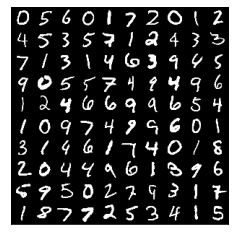

In [128]:
# Layer 1 Predictions of each class
final_l1_images = images_of_layer(l1_pred)
imshow(make_grid(final_l1_images, nrow=10))

### Layer 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


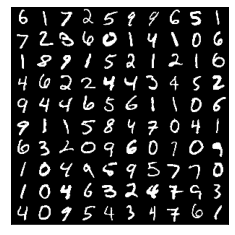

In [129]:
# Layer 2 Predictions of each class
final_l2_images = images_of_layer(l2_pred)
imshow(make_grid(final_l2_images, nrow=10))

### Layer 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


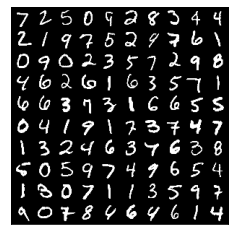

In [130]:
# Layer 3 Predictions of each class
final_l3_images = images_of_layer(l3_pred)
imshow(make_grid(final_l3_images, nrow=10))

### Layer 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


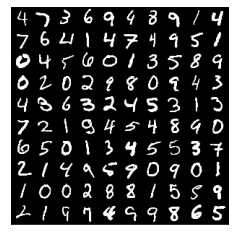

In [131]:
# Layer 4 Predictions of each class
final_l4_images = images_of_layer(l4_pred)
imshow(make_grid(final_l4_images, nrow=10))

### Layer 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


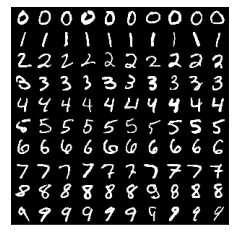

In [132]:
# Layer 5 Predictions of each class
final_l5_images = images_of_layer(predict)
imshow(make_grid(final_l5_images, nrow=10))

# Report:
- From Layer 5 plot we can see that most of the predictions are correct and plot was as expected with 0,1,2... in each row. Basically, it means that they are able to discriminate amongst the 10 classes available with an accuracy of more than 98%.

- However the plot of the layer 1-4 says differently because of the randomization effect while predicting the labels which clearly doesn't make sense.


 

## T-SNE

In [133]:
# Load Data
images = next(iter(sample_testloader))[0].cpu().numpy()
labels = next(iter(sample_testloader))[1].cpu().numpy()

# # Faltten Images
flatten_images = np.array([i.flatten() for i in images])

In [134]:
# Plot Theme 
# sns.set_style(style='darkgrid')
# sns.set_theme()
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

customPalette = cm.get_cmap('viridis', 10)

def plot(data):
    plt.figure(figsize=(15,10))
    for label in range(10):

        #add data points 
        plt.scatter(x=data.loc[data['label']==label, 'x'], 
                    y=data.loc[data['label']==label,'y'],
                    s=10,
                    color=customPalette(label), 
                    marker = '.')
        
        #add label
        plt.annotate(label, 
                    data.loc[data['label']==label,['x','y']].mean(),
                    horizontalalignment='center',
                    verticalalignment='center',
                    size=20, weight='bold',
                    color= 'black',
                    backgroundcolor=customPalette(label))
                    # color=customPalette(label))
        

def tsne(data):
    tsne = TSNE(n_jobs=4).fit_transform(data)
    data = pd.DataFrame({'label': labels, 'x': tsne[:,0], 'y': tsne[:,1]})
    return data

def pca(data):
    pca = PCA(n_components=2).fit_transform(data) 
    data = pd.DataFrame({'label': labels, 'x': pca[:,0], 'y': pca[:,1]})
    return data

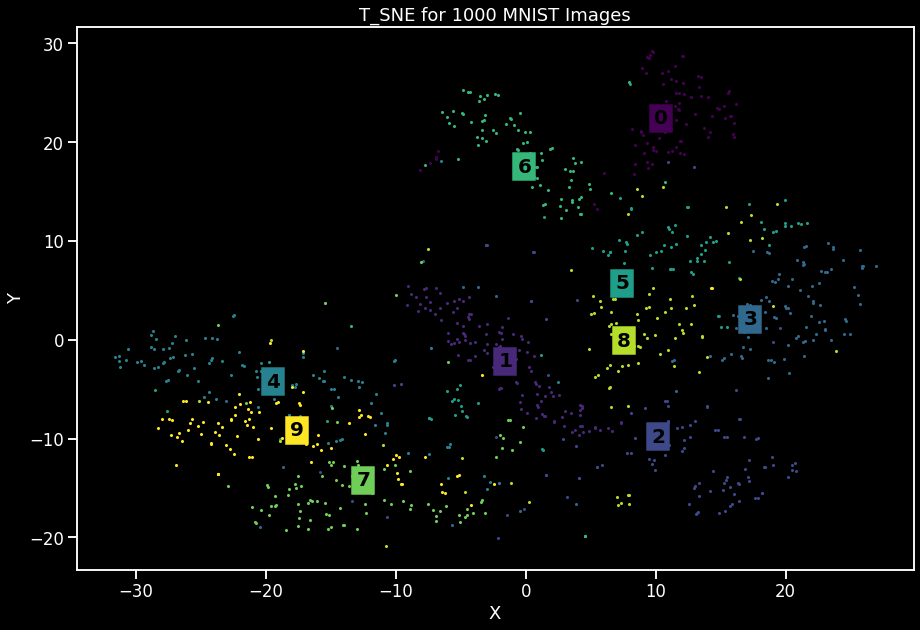

In [135]:
plot(tsne(flatten_images))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("T_SNE for 1000 MNIST Images")
plt.show()

## PCA

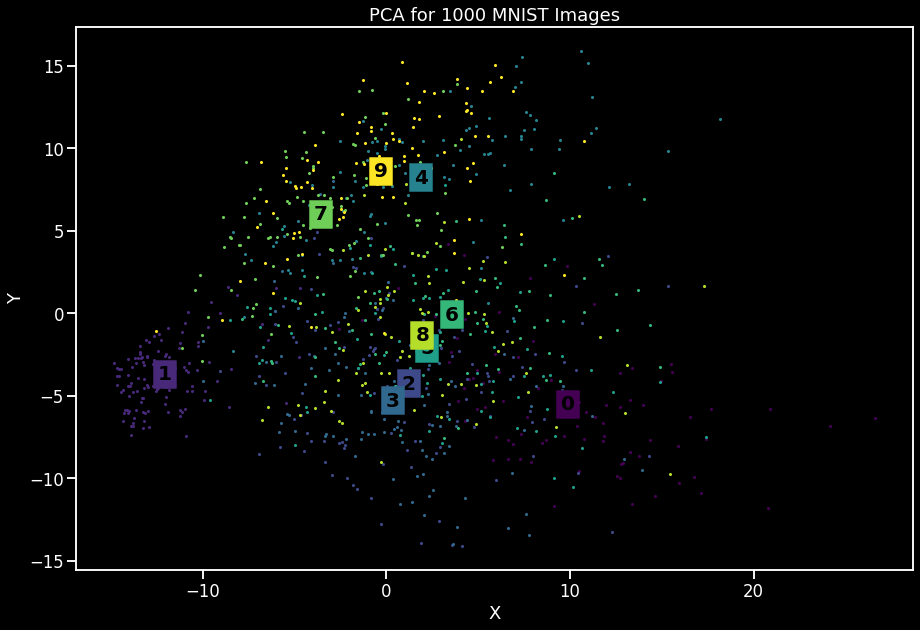

In [136]:
plot(pca(flatten_images))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("PCA for 1000 MNIST Images")
plt.show()

# Report:
- While TSNE plot tries to distinguish between the labels, we cannot draw any conclusions from PCA.
- As the data is sparsely distributed we cannot classify clearly from either one of them.

In [137]:
l1_ = torch.cat(l1)
l1_ = torch.reshape(l1_, (1000, 1024))
l2_ = torch.cat(l2)
l2_ = torch.reshape(l2_, (1000, 1024))
l3_ = torch.cat(l3)
l3_ = torch.reshape(l3_, (1000, 1024))
l4_ = torch.cat(l4)
l4_ = torch.reshape(l4_, (1000, 1024))
l5_ = torch.cat(l5)
l5_ = torch.reshape(l5_, (1000, 10))

### Layer 1 T-sne and PCA

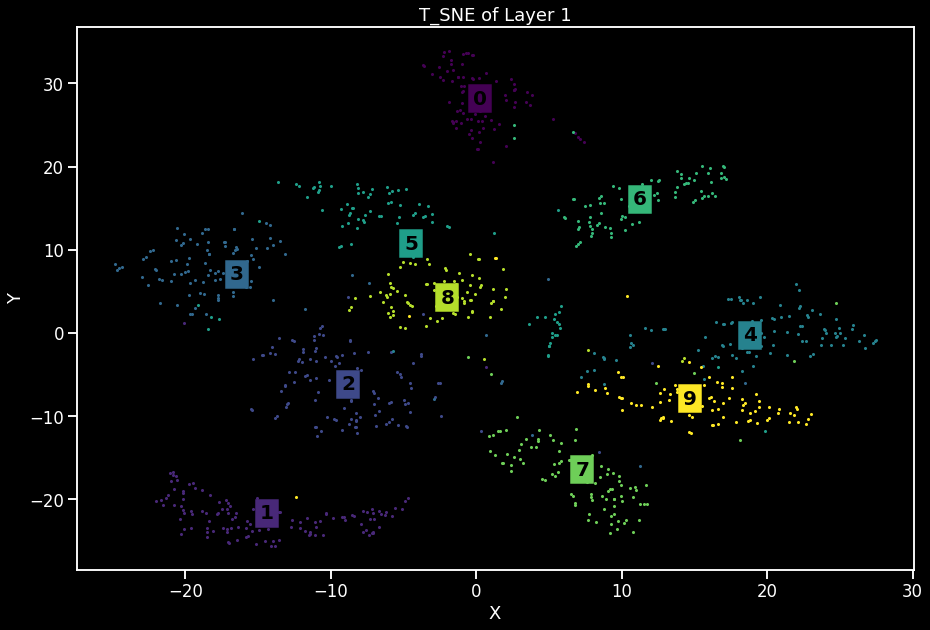

In [138]:
plot(tsne(l1_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("T_SNE of Layer 1")
plt.show()

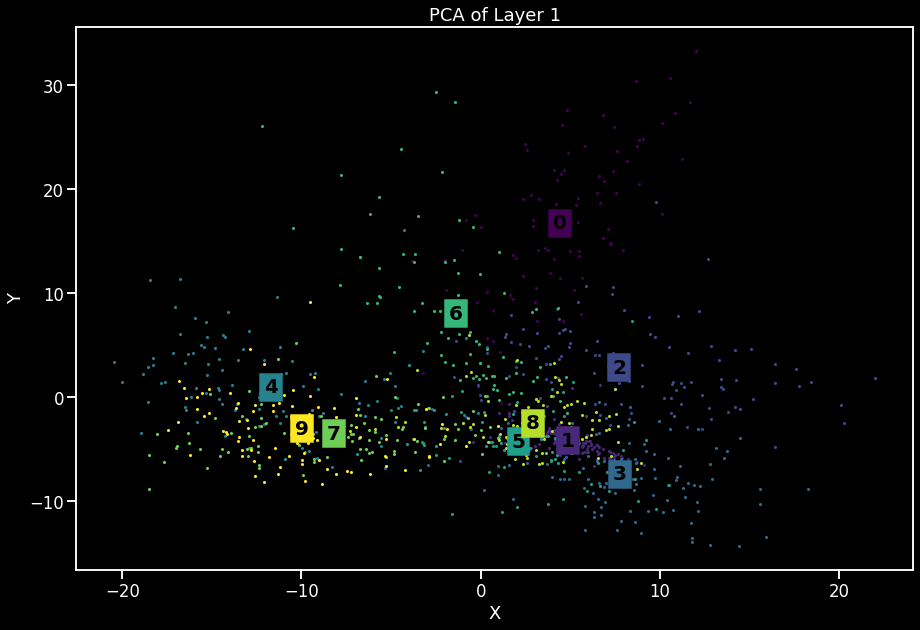

In [139]:
plot(pca(l1_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("PCA of Layer 1")
plt.show()

### Layer 2 T-SNE and PCA

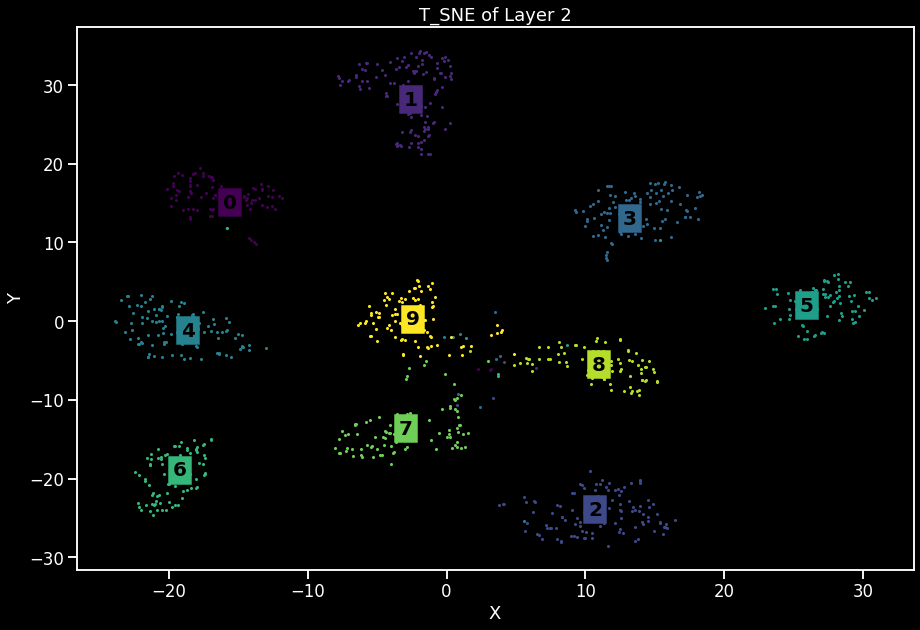

In [140]:
plot(tsne(l2_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("T_SNE of Layer 2")
plt.show()

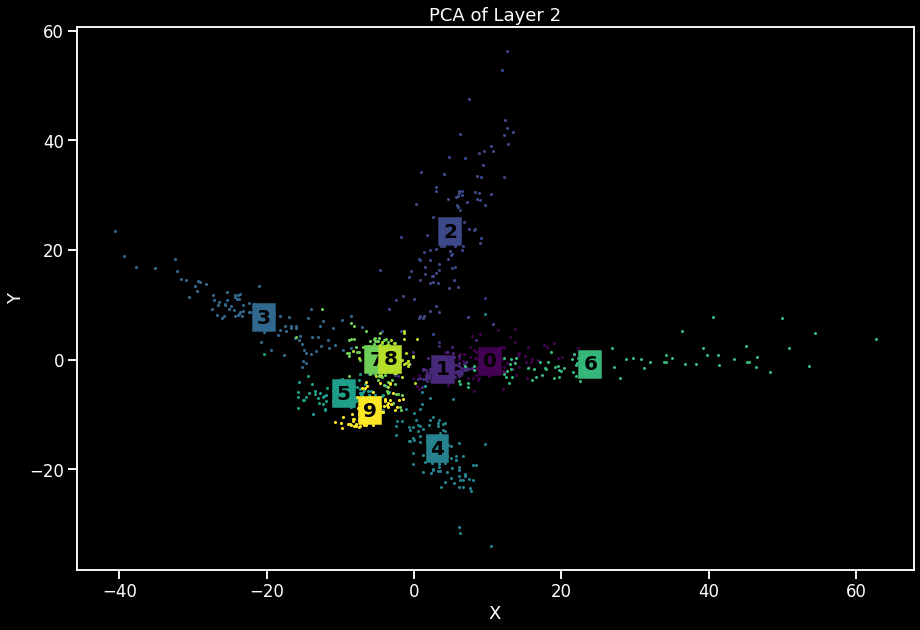

In [141]:
plot(pca(l2_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("PCA of Layer 2")
plt.show()

### Layer 3 T-SNE and PCA

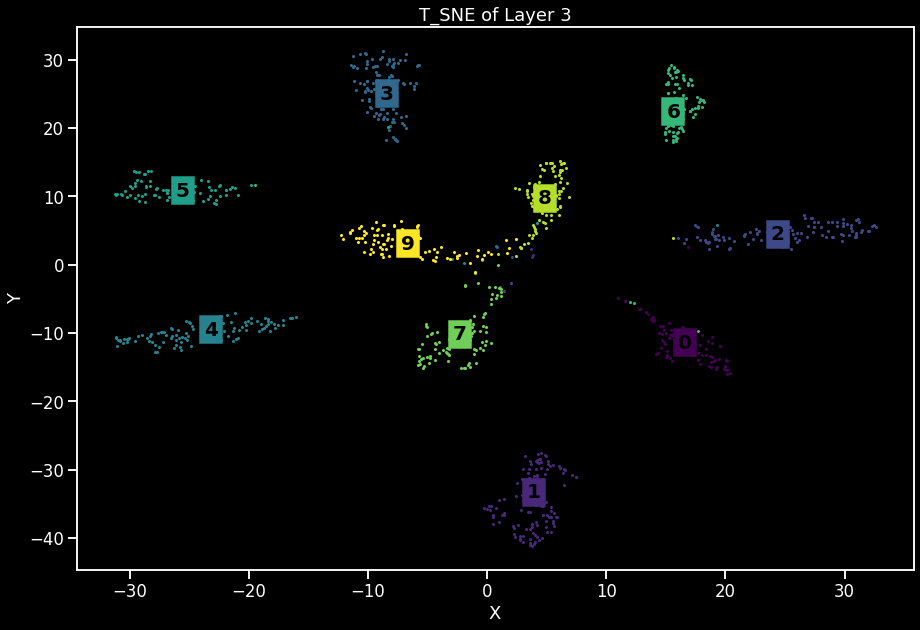

In [142]:
customPalette = cm.get_cmap('viridis', 10)
plot(tsne(l3_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("T_SNE of Layer 3")
plt.show()

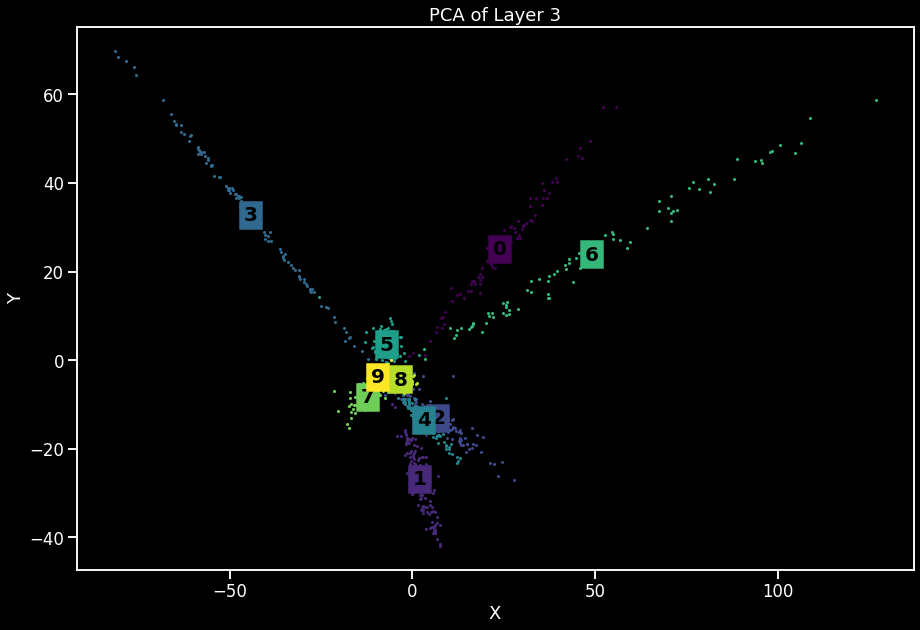

In [143]:
plot(pca(l3_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("PCA of Layer 3")
plt.show()

### Layer 4 T-SNE and PCA

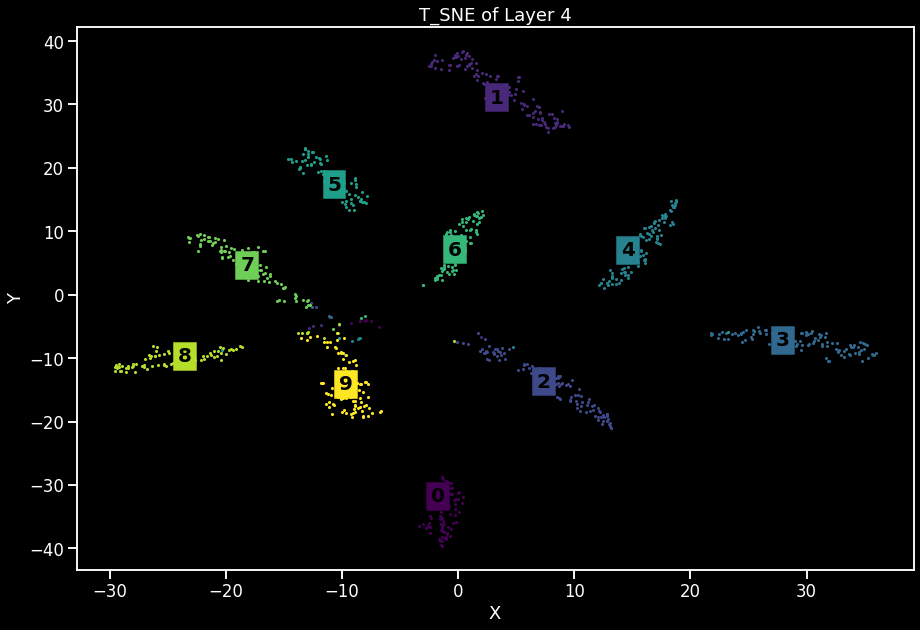

In [144]:
plot(tsne(l4_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("T_SNE of Layer 4")
plt.show()

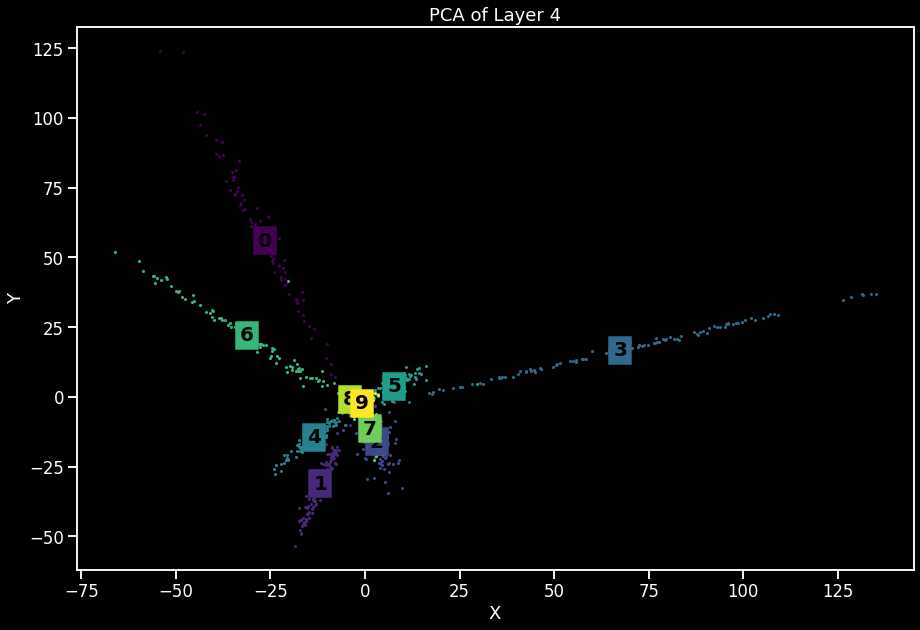

In [145]:
plot(pca(l4_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("PCA of Layer 4")
plt.show()

### Layer 5 T-SNE and PCA

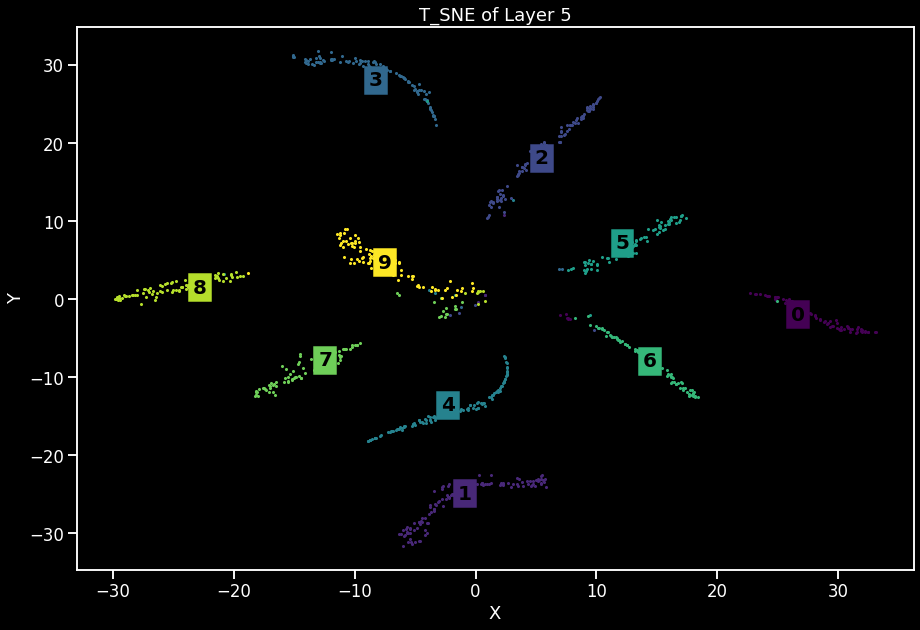

In [146]:
plot(tsne(l5_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("T_SNE of Layer 5")
plt.show()

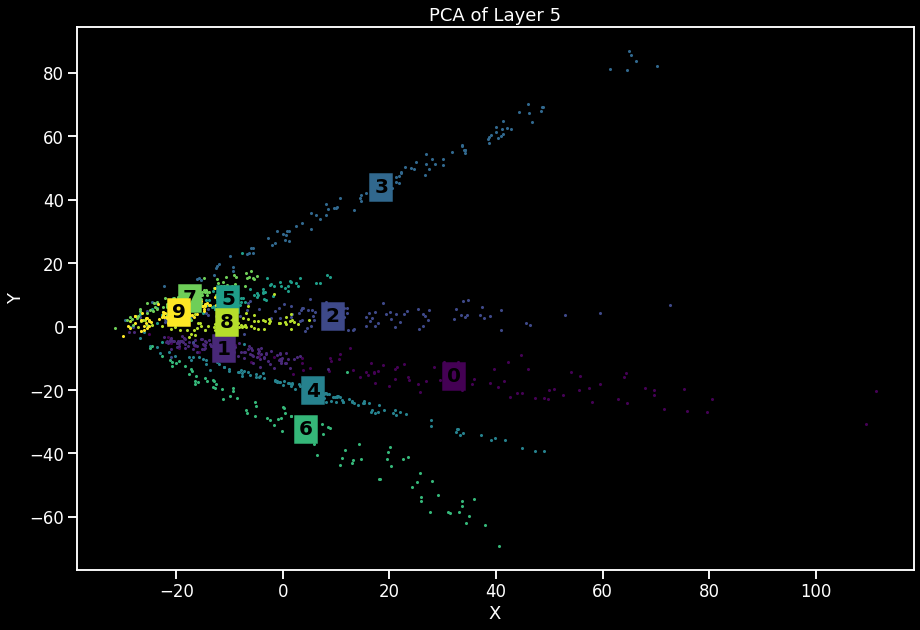

In [147]:
plot(pca(l5_.detach().cpu()))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("PCA of Layer 5")
plt.show()

# Report:
- We can observe that the clustering starts to improve from layer 1 to layer 5 in both TSNE and PCA 
- TSNE tends to represnts the clusters clearly than PCA.
- We can state that each layer is able to distinguish features from the data  better than their previous layers 

# Problem 2: Speech Denoising Using Deep Learning

In [189]:
# !pip install librosa # in colab, you’ll need to install this 
import librosa
import IPython.display as ipd
from scipy.io import wavfile

### Load Data

In [190]:
s, sr=librosa.load('train_clean_male.wav', sr=None) 
S=librosa.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('train_dirty_male.wav', sr=None) 
X=librosa.stft(sn, n_fft=1024, hop_length=512)
S, X = np.abs(S), np.abs(X)
S = torch.tensor(np.transpose(S)).to(device)
X = torch.tensor(np.transpose(X)).to(device)
BATCH_SIZE = 150
TrainLoader = torch.utils.data.DataLoader(X, batch_size=BATCH_SIZE)
TestLoader = torch.utils.data.DataLoader(S, batch_size=BATCH_SIZE)

### Model

In [191]:
class DeNoiseNetwork(nn.Module):

    def __init__(self, activation_func='relu', weight_init=None, batch_norm=False, dropout=False):
        super().__init__()

        # Pass Variables:
        self.activation_func = activation_func
        self.weight_init = weight_init
        self.dropout = dropout
        self.batch_norm = batch_norm

        # Define Layers:
        self.l1 = nn.Linear(513, 2565)
        self.l2 = nn.Linear(2565, 2052)
        self.l3 = nn.Linear(2052, 1539)
        self.l4 = nn.Linear(1539, 1026)
        self.l5 = nn.Linear(1026, 513)

        # Batch Normalization:
        self.b1 = nn.BatchNorm1d(2565)
        self.b2 = nn.BatchNorm1d(2052)
        self.b3 = nn.BatchNorm1d(1539)
        self.b4 = nn.BatchNorm1d(1026)

        # Define Activation functions:
        if self.activation_func == 'le_relu':
            # print("Log_sig")
            self.activation = nn.LeakyReLU() # Logistic Sigmoid.
        elif self.activation_func == 'relu':
            # print("relu")
            self.activation = nn.ReLU() # ReLU 

        self.dropout1 = nn.Dropout(p=0.2)

        if self.weight_init == None:
            pass
        elif self.weight_init == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # print("Xavier")
                    nn.init.xavier_normal_(m.weight, gain=1.0)
        elif self.weight_init == 'he':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # print("He")
                    if self.activation_func == 'relu':
                        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                    else:
                        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        # Pass the input tensor x through our layers:
        x = x.view(-1, 513).to(device)

        # Layer 1
        x = self.l1(x)
        if self.batch_norm:
            x = self.b1(x)
        x = self.activation(x)
        if self.dropout:
            x = self.dropout1(x)
        
        # Layer 2
        x = self.l2(x)
        if self.batch_norm:
            x = self.b2(x)
        x = self.activation(x)
        if self.dropout:
            x = self.dropout1(x)

        # Layer 3
        x = self.l3(x)
        if self.batch_norm:
            x = self.b3(x)
        x = self.activation(x)
        if self.dropout:
            x = self.dropout1(x)

        # Layer 4
        x = self.l4(x)
        if self.batch_norm:
            x = self.b4(x)
        x = self.activation(x)
        if self.dropout:
            x = self.dropout1(x)

        # Layer 5
        x = self.l5(x)
        x = torch.nn.functional.relu(x)

        # x = torch.nn.functional.relu(self.l5(x))

        return x



In [176]:
def train_model(model):
    # Loss Function
    criterion = nn.MSELoss()

    # Loss Optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    # No:of times to train data
    epochs = 200
    loss_of_each_epoch = []

    for e in tqdm(range(epochs)):
        train_running_loss = 0.0
        train_acc = 0.0
        for (input, output) in zip(TrainLoader, TestLoader):
            # Convert the input to required format 
            input = input.to(device)
            output = output.to(device)

            # set optimizer gradients to zero:
            optimizer.zero_grad()

            predictions = model(input) # Output predictions
            loss = criterion(predictions, output) # Loss  Caluclation
            loss.backward() # Pass loss function gradients to pervious layers:
            optimizer.step() # Update Weights
        loss_of_each_epoch.append(loss.data.cpu().numpy())
    print(loss.data)
    plt.plot(range(epochs), loss_of_each_epoch)
    plt.show()

In [193]:
model = DeNoiseNetwork(activation_func='relu', weight_init='he', batch_norm=False, dropout=False).to(device)

### Train Model


tensor(0.0005, device='cuda:0')


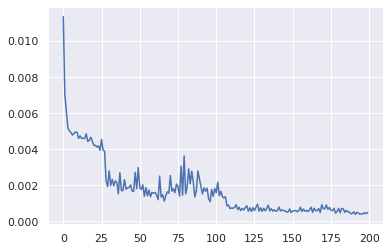

In [194]:
train_model(model)

In [204]:
PATH = './DN_MODEL.pth'
torch.save(model.state_dict(), PATH) 

# Load Model
# NN = NeuralNetwork().to(device)
# NN.load_state_dict(torch.load(PATH))

In [195]:
def audio_test(input_file, output_file, model):
    s, sr = librosa.load(input_file, sr=None) 
    temp = librosa.stft(s, n_fft=1024, hop_length=512)
    temp_abs = torch.tensor(np.abs(temp))
    temp_abs = np.transpose(temp_abs)
    TempLoader = torch.utils.data.DataLoader(temp_abs, batch_size=temp_abs.shape[0])
    with torch.no_grad():
        for i in TempLoader:
            i = i.to(device)
            output = model(i)
        print(temp.shape)
        print(output.shape)
        recov = (temp/np.abs(temp)) * output.detach().cpu().numpy().T
        recov_istft = librosa.istft(recov, hop_length=512)
        librosa.output.write_wav(output_file, recov_istft, sr)
        # ipd.Audio(input_file)
        # ipd.Audio(output_file)

#### Test Audio 1

In [196]:
# Testing audio 1
audio_test('test_x_01.wav', 'test_x_01_recons_model.wav', model)

(513, 142)
torch.Size([142, 513])


In [19]:
ipd.Audio('test_x_01.wav')

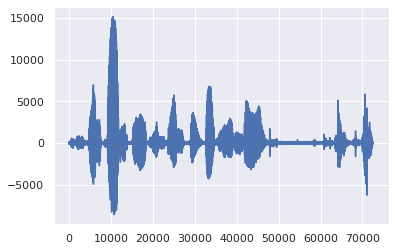

In [202]:
samplingFrequency, signalData = wavfile.read('test_x_01.wav')
plt.plot(signalData)

In [197]:
ipd.Audio('test_x_01_recons_model.wav')

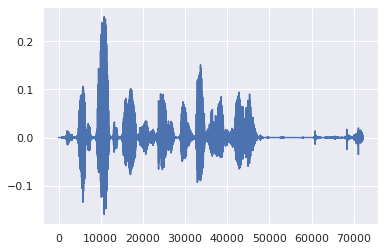

In [198]:
samplingFrequency, signalData = wavfile.read('test_x_01_recons_model.wav')
plt.plot(signalData)

#### Test Audio 2

In [199]:
# Testing audio 2
audio_test('test_x_02.wav', 'test_x_02_recons_model.wav', model)

(513, 380)
torch.Size([380, 513])


In [25]:
ipd.Audio('test_x_02.wav')

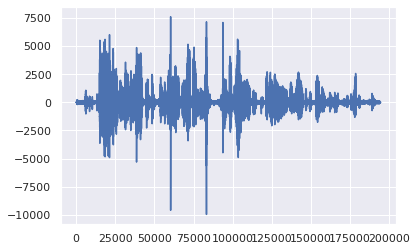

In [203]:
samplingFrequency, signalData = wavfile.read('test_x_02.wav')
plt.plot(signalData)

In [200]:
ipd.Audio('test_x_02_recons_model.wav')

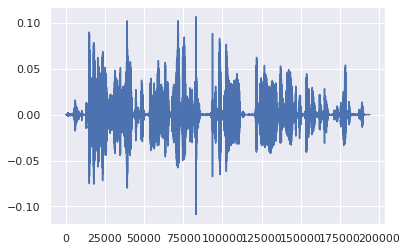

In [201]:
samplingFrequency, signalData = wavfile.read('test_x_02_recons_model.wav')
plt.plot(signalData)

# Problem 3: Adult Optimization

In [ ]:
class AdultOptimization(nn.Module):

    def __init__(self, activation_func='log_sig', weight_init='he', dropout=False):
        super().__init__()

        # Pass Variables:
        self.activation_func = activation_func
        self.weight_init = weight_init
        self.dropout = dropout

        # Define Layers:
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 10)

        # Batch Normalization
        self.b1 = nn.BatchNorm1d(512)
        self.b2 = nn.BatchNorm1d(512)
        self.b3 = nn.BatchNorm1d(512)
        self.b4 = nn.BatchNorm1d(512)
        # self.b5 = nn.BatchNorm1d(512)

        # Define Activation functions:
        if self.activation_func == 'log_sig':
            # print("Log_sig")
            self.activation = nn.LogSigmoid() # Logistic Sigmoid.
        elif self.activation_func == 'relu':
            # print("relu")
            self.activation = nn.ReLU() # ReLU 
        self.softmax = nn.LogSoftmax(dim = 1) # SoftMax
        
        # self.dropout1 = nn.Dropout(p=0.2)
        # self.dropout2 = nn.Dropout(p=0.5)

        # Intialize weights:
        if self.weight_init == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # print("Normal")
                    nn.init.normal_(m.weight, mean=0.0, std=0.01)
        elif self.weight_init == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # print("Xavier")
                    nn.init.xavier_normal_(m.weight, gain=1.0)
        elif self.weight_init == 'he':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # print("He")
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')


    def forward(self, x):
        # Pass the input tensor x through our layers:
        # print("Start")
        x = self.l1(x)
        # x = self.b1(x)
        x = self.activation(x)
        # if self.dropout:
        #     # print("dropout")
        #     x = self.dropout1(x)
        

        x = self.l2(x)
        # x = self.b2(x)
        x = self.activation(x)
        # if self.dropout:
        #     # print("dropout")
        #     x = self.dropout2(x)
        

        x = self.l3(x)
        # x = self.b3(x)
        x = self.activation(x)
        # if self.dropout:
        #     # print("dropout")
        #     x = self.dropout2(x)

        x = self.l4(x)
        # x = self.b4(x)
        x = self.activation(x)
        # if self.dropout:
        #     # print("dropout")
        #     x = self.dropout2(x)

        x = self.l5(x)
        out = self.softmax(x)

        return out


In [ ]:
# Define Models:
modelA = AdultOptimization(activation_func='log_sig', weight_init='normal').to(device)
modelB = AdultOptimization(activation_func='log_sig', weight_init='xavier').to(device)
modelC = AdultOptimization(activation_func='relu', weight_init='normal').to(device)
modelD = AdultOptimization(activation_func='relu', weight_init='xavier').to(device)
modelE = AdultOptimization(activation_func='relu', weight_init='he').to(device)

In [ ]:
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for each iteration '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
def train_model(model, optimizer='adam', lr=1.0, epochs=200):
    # Loss Function:
    criterion = nn.NLLLoss()

    # Loss Optimizer:
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    test_loss = []

    # model.train() # Start Training Phase
    for e in tqdm(range(epochs)):
        model.train() # Start Training Phase
        for i, (images, labels) in enumerate(trainloader):
            # Faltten the images
            images = images.view(images.shape[0], -1)
            images, labels = images.to(device), labels.to(device)

            # set optimizer gradients to zero:
            optimizer.zero_grad()

            predictions = model(images) # Output predictions
            loss = criterion(predictions, labels) # Loss  Caluclation
            loss.backward() # Pass loss function gradients to pervious layers:
            optimizer.step() # Update Weights
        
        model.eval() # Start Evaluation Phase
        with torch.no_grad():
            for (images, labels) in testloader:
                images = images.view(images.shape[0], -1)
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                test_acc = get_accuracy(output, labels, 10000)
        # print(test_acc)
        test_loss.append(test_acc)

    return test_loss


In [ ]:
log_norm_adam = train_model(modelA, optimizer='adam', epochs=50)
log_xav_adam = train_model(modelB, optimizer='adam', epochs=50)
relu_norm_adam = train_model(modelC, optimizer='adam', epochs=50)
relu_xav_adam = train_model(modelD, optimizer='adam', epochs=50)
relu_he_adam = train_model(modelE, optimizer='adam', epochs=50)

In [ ]:
log_norm_sgd = train_model(modelA, optimizer='sgd', lr=1.0, epochs=50)
log_xav_sgd = train_model(modelB, optimizer='sgd', lr=0.1, epochs=50)
relu_norm_sgd = train_model(modelC, optimizer='sgd', lr=0.1, epochs=50)
relu_xav_sgd = train_model(modelD, optimizer='sgd', lr=0.1, epochs=50)
relu_he_sgd = train_model(modelE, optimizer='sgd', lr=0.1, epochs=50)

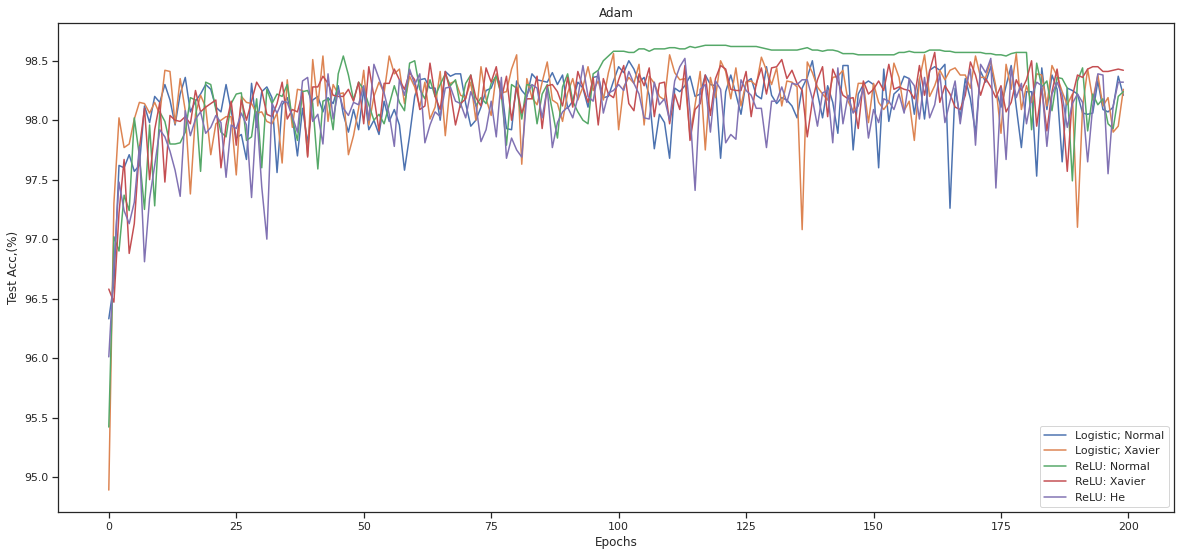

In [ ]:
n = 200
plt.figure(figsize=(20,9))
sns.set_style(style='ticks')
plt.plot(range(n), log_norm_adam, label='Logistic; Normal')
plt.plot(range(n), log_xav_adam, label='Logistic; Xavier')
plt.plot(range(n), relu_norm_adam, label='ReLU: Normal')
plt.plot(range(n), relu_xav_adam, label='ReLU: Xavier')
plt.plot(range(n), relu_he_adam, label='ReLU: He')
plt.title("Adam")
plt.xlabel("Epochs")
plt.ylabel("Test Acc,(%)")
plt.legend(loc='lower right')
plt.show()

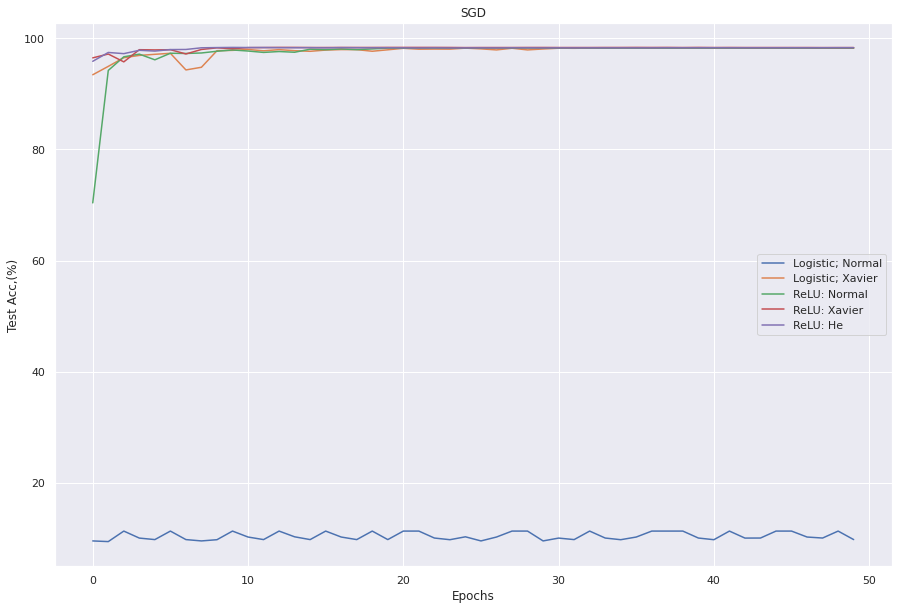

In [209]:
n = 50
plt.figure(figsize=(15,10))
sns.set_theme()
plt.plot(range(n), log_norm_sgd[:50], label='Logistic; Normal')
plt.plot(range(n), log_xav_sgd[:50], label='Logistic; Xavier')
plt.plot(range(n), relu_norm_sgd[:50], label='ReLU: Normal')
plt.plot(range(n), relu_xav_sgd[:50], label='ReLU: Xavier')
plt.plot(range(n), relu_he_sgd[:50], label='ReLU: He')
plt.title("SGD")
plt.xlabel("Epochs")
plt.ylabel("Test Acc,(%)")
plt.legend(loc='center right')
plt.show()

# Problem 4: Dropout

## Model

In [ ]:
class AdultOptimization(nn.Module):

    def __init__(self, activation_func='log_sig', weight_init='he', dropout=False):
        super().__init__()

        # Pass Variables:
        self.activation_func = activation_func
        self.weight_init = weight_init
        self.dropout = dropout

        # Define Layers:
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 10)

        # Batch Normalization
        self.b1 = nn.BatchNorm1d(512)
        self.b2 = nn.BatchNorm1d(512)
        self.b3 = nn.BatchNorm1d(512)
        self.b4 = nn.BatchNorm1d(512)
        # self.b5 = nn.BatchNorm1d(512)

        # Define Activation functions:
        if self.activation_func == 'log_sig':
            # print("Log_sig")
            self.activation = nn.LogSigmoid() # Logistic Sigmoid.
        elif self.activation_func == 'relu':
            # print("relu")
            self.activation = nn.ReLU() # ReLU 
        # self.softmax = nn.LogSoftmax(dim = 1) # SoftMax
        
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)

        # Intialize weights:
        if self.weight_init == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # print("Normal")
                    nn.init.normal_(m.weight, mean=0.0, std=0.01)
        elif self.weight_init == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # print("Xavier")
                    nn.init.xavier_normal_(m.weight, gain=1.0)
        elif self.weight_init == 'he':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    # print("He")
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')


    def forward(self, x):
        # Pass the input tensor x through our layers:
        # print("Start")
        x = self.l1(x)
        x = self.b1(x)
        x = self.activation(x)
        if self.dropout:
            # print("dropout")
            x = self.dropout1(x)
        

        x = self.l2(x)
        x = self.b2(x)
        x = self.activation(x)
        if self.dropout:
            # print("dropout")
            x = self.dropout2(x)
        

        x = self.l3(x)
        x = self.b3(x)
        x = self.activation(x)
        if self.dropout:
            # print("dropout")
            x = self.dropout2(x)

        x = self.l4(x)
        x = self.b4(x)
        x = self.activation(x)
        if self.dropout:
            # print("dropout")
            x = self.dropout2(x)

        x = self.l5(x)
        # out = self.softmax(x)

        return x


In [ ]:
# Define Models
model_log_xav = AdultOptimization(activation_func='log_sig', weight_init='xavier').to(device)
model_log_xav_drp = AdultOptimization(activation_func='log_sig', weight_init='xavier', dropout=True).to(device)
model_rel_he = AdultOptimization(activation_func='relu', weight_init='he').to(device)
model_rel_he_drp = AdultOptimization(activation_func='relu', weight_init='he', dropout=True).to(device)

In [ ]:
def train_model(model, epochs=100):
    # Loss Function:
    criterion = nn.CrossEntropyLoss()

    # Loss Optimizer:
    optimizer = optim.Adam(model.parameters())

    test_loss = []
    train_loss = []

    # model.train() # Start Training Phase
    for e in tqdm(range(epochs)):
        model.train() # Start Training Phase
        train_running_loss = 0
        for i, (images, labels) in enumerate(trainloader):
            # Faltten the images
            images = images.view(images.shape[0], -1)
            images, labels = images.to(device), labels.to(device)

            # set optimizer gradients to zero:
            optimizer.zero_grad()

            predictions = model(images) # Output predictions
            loss = criterion(predictions, labels) # Loss  Caluclation
            loss.backward() # Pass loss function gradients to pervious layers:
            optimizer.step() # Update Weights

            train_running_loss += loss.detach().item()
        train_loss.append(round(train_running_loss/i, 3))
        
        model.eval() # Start Evaluation Phase
        with torch.no_grad():
            for (images, labels) in testloader:
                images = images.view(images.shape[0], -1)
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                tes_loss = criterion(output, labels)
                test_acc = tes_loss.detach().item()
        # print(test_acc)
        test_loss.append(test_acc)

    return train_loss, test_loss

### Train Models

In [ ]:
log_xav_train, log_xav_test = train_model(model_log_xav, epochs=250)
log_xav_drp_train, log_xav_drp_test = train_model(model_log_xav_drp, epochs=250)
rel_he_train, rel_he_test = train_model(model_rel_he, epochs=250)
rel_he_drp_train, rel_he_drp_test = train_model(model_rel_he_drp, epochs=250)

### 1024x5 Logistic

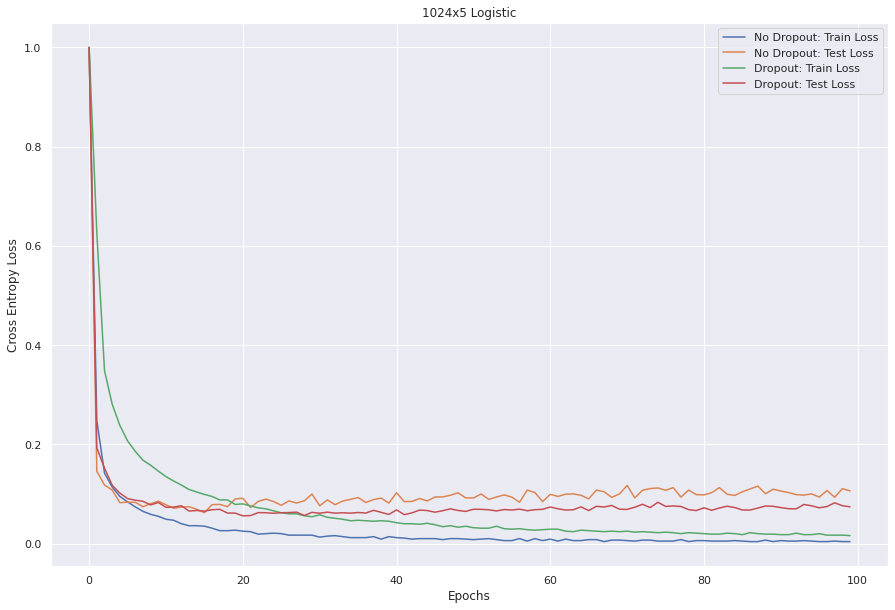

In [162]:
plt.figure(figsize=(15,10))
sns.set_theme()
plt.plot(range(100), [1]+log_xav_train[:99], label='No Dropout: Train Loss')
plt.plot(range(100), [1]+log_xav_test[:99], label='No Dropout: Test Loss')
plt.plot(range(100), [1]+log_xav_drp_train[:99], label='Dropout: Train Loss')
plt.plot(range(100), [1]+log_xav_drp_test[:99], label='Dropout: Test Loss')
plt.title("1024x5 Logistic")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend(loc='upper right')
plt.show()

### 1024x5 ReLU

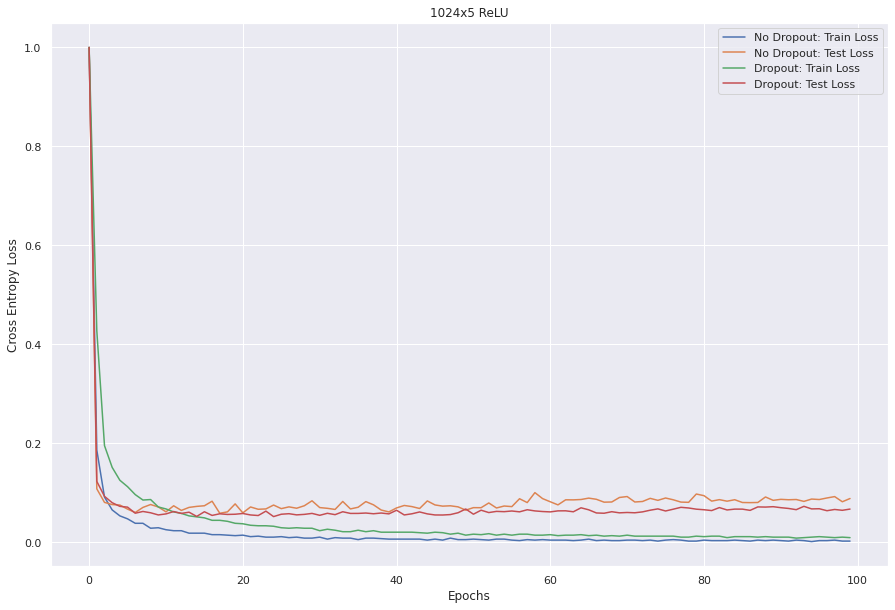

In [163]:
plt.figure(figsize=(15,10))
sns.set_theme()
plt.plot(range(100), [1]+rel_he_train[:99], label='No Dropout: Train Loss')
plt.plot(range(100), [1]+rel_he_test[:99], label='No Dropout: Test Loss')
plt.plot(range(100), [1]+rel_he_drp_train[:99], label='Dropout: Train Loss')
plt.plot(range(100), [1]+rel_he_drp_test[:99], label='Dropout: Test Loss')
plt.title("1024x5 ReLU")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend(loc='upper right')
plt.show()